# Uncertainty Quantification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import sys
import importlib

sys.path.append('../scripts/')
import FeatureEngineering
importlib.reload(FeatureEngineering)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [2]:

path = '../data/consolidated/'
weather_data = pd.read_csv(path+'consolidated_weather_from_centroids.csv')
demand_data = pd.read_csv(path+'consolidatedIESOdemand.csv')
price_data = pd.read_csv(path+'prices_zonal.csv')

# convert temperature
columns = list(weather_data.columns)
columns[0] = 'Hour'
weather_data.columns = columns
weather_data['temp_C_t2m'] = weather_data['t2m'] - 273.15

# create proper dataset
dataset = FeatureEngineering.CleanedDataset(weather_data, demand_data, price_data)
datamerged = dataset.merge_datasets()
datamerged = dataset.add_calendar_features(datamerged)

datamerged = datamerged[
    (datamerged['Date'].dt.year >= 2018) & 
    (datamerged['Date'].dt.year <= 2024)
]

print(f"Dataset shape: {datamerged.shape}")

/var/folders/b8/b4rqhqs11cbcqlzjryxb92lw0000gn/T/ipykernel_8222/2583753750.py:3: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  demand_data = pd.read_csv(path+'consolidatedIESOdemand.csv')


Dataset shape: (613680, 46)


In [3]:
#create dummy variables for hour, month, weekday


print(datamerged.head())
print(datamerged.columns)


datamerged['Date'] = pd.to_datetime(datamerged['Date'])

# create dummy variables for hour, month, weekday
datamerged['hour'] = datamerged['Date'].dt.hour
datamerged['month'] = datamerged['Date'].dt.month
datamerged['weekday'] = datamerged['Date'].dt.weekday

# one hot
dummies = pd.get_dummies(datamerged[['hour', 'month', 'weekday']], columns=['hour', 'month', 'weekday'], prefix=['hour', 'month', 'weekday'])


datamerged = pd.concat([datamerged, dummies], axis=1)


print(datamerged.columns)

print(datamerged.filter(regex='hour_|month_|weekday_').head())

                    Date  Hour  Ontario Demand  Northwest  Northeast  Ottawa  \
6144 2021-08-27 00:00:00     0           15722        421       1110    1035   
6145 2021-08-27 01:00:00     1           14963        430       1098     967   
6146 2021-08-27 02:00:00     2           14547        425       1083     925   
6147 2021-08-27 03:00:00     3           14377        423       1058     915   
6148 2021-08-27 04:00:00     4           14489        420       1007     937   

      East  Toronto  Essa  Bruce  Southwest  Niagara  West  Zone Total Diff  \
6144   959     5893   969     86       3168      541  1774       15958  236   
6145   883     5609   903     84       3017      521  1713       15225  262   
6146   860     5424   856     83       2917      503  1673       14750  203   
6147   843     5352   834     81       2882      503  1671       14562  185   
6148   873     5464   844     77       2901      510  1695       14727  239   

      Year    u10     v10      d2m      t2m 

In [4]:
datamerged.head()

,Date,Hour,Ontario Demand,Northwest,Northeast,Ottawa,East,Toronto,Essa,Bruce,Southwest,Niagara,West,Zone Total,Diff,Year,u10,v10,d2m,t2m,ssrd,tp,latitude,longitude,file,temp_C_t2m,Hour_of_Day,Reference_Richview,North West_Atikokan,North West_Pineportage,North West_Thunderbay,North East_Andrews,North East_Canyon,North East_NPIroqfalls,Ottawa_TAOHSC,East_Saunders,Toronto_Darlington,Essa_Desjoachims,Bruce_BruceB,South West_GerdauCam,Niagara_BECK2,West_Greenfield,Month,Day,Weekday,IsHoliday,hour,month,weekday,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
6144,2021-08-27 00:00:00,0,15722,421,1110,1035,959,5893,969,86,3168,541,1774,15958,236,2021,1.3209,-1.6267,291.0809,298.6181,97280.0000,0.0000,45.5000,-75.2500,Ottawa_centroid_weather,25.4681,1,11.6900,9.8200,5.8300,NaN,10.8200,11.3500,11.1300,11.5700,11.4600,11.5700,11.5700,11.3500,11.6900,11.4600,11.6900,8,27,4,0,0,8,4,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False
6145,2021-08-27 01:00:00,1,14963,430,1098,967,883,5609,903,84,3017,521,1713,15225,262,2021,1.1488,-2.6252,291.4425,298.6062,0.0000,0.0000,45.5000,-75.2500,Ottawa_centroid_weather,25.4562,2,6.1000,7.9300,8.2200,NaN,5.6500,5.9200,5.8100,6.0400,5.9800,6.0400,6.0400,5.9200,6.1000,5.9800,6.1000,8,27,4,0,1,8,4,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False
6146,2021-08-27 02:00:00,2,14547,425,1083,925,860,5424,856,83,2917,503,1673,14750,203,2021,0.9666,-3.1990,290.4534,295.9456,0.0000,0.0000,45.5000,-75.2500,Ottawa_centroid_weather,22.7956,3,6.0900,20.3000,22.4200,NaN,5.6400,5.9100,5.8000,6.0300,5.9700,6.0300,6.0300,5.9100,6.0900,5.9700,6.0900,8,27,4,0,2,8,4,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False
6147,2021-08-27 03:00:00,3,14377,423,1058,915,843,5352,834,81,2882,503,1671,14562,185,2021,0.8862,-3.6591,290.0759,295.7738,0.0000,0.0000,45.5000,-75.2500,Ottawa_centroid_weather,22.6238,4,0.0000,30.0200,34.4400,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,8,27,4,0,3,8,4,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False
6148,2021-08-27 04:00:00,4,14489,420,1007,937,873,5464,844,77,2901,510,1695,14727,239,2021,0.6232,-4.3728,289.1558,295.6415,0.0000,0.0000,45.5000,-75.2500,Ottawa_centroid_weather,22.4915,5,0.0000,13.9300,15.9800,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,8,27,4,0,4,8,4,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False


In [5]:
datamerged.head(5)

,Date,Hour,Ontario Demand,Northwest,Northeast,Ottawa,East,Toronto,Essa,Bruce,Southwest,Niagara,West,Zone Total,Diff,Year,u10,v10,d2m,t2m,ssrd,tp,latitude,longitude,file,temp_C_t2m,Hour_of_Day,Reference_Richview,North West_Atikokan,North West_Pineportage,North West_Thunderbay,North East_Andrews,North East_Canyon,North East_NPIroqfalls,Ottawa_TAOHSC,East_Saunders,Toronto_Darlington,Essa_Desjoachims,Bruce_BruceB,South West_GerdauCam,Niagara_BECK2,West_Greenfield,Month,Day,Weekday,IsHoliday,hour,month,weekday,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
6144,2021-08-27 00:00:00,0,15722,421,1110,1035,959,5893,969,86,3168,541,1774,15958,236,2021,1.3209,-1.6267,291.0809,298.6181,97280.0000,0.0000,45.5000,-75.2500,Ottawa_centroid_weather,25.4681,1,11.6900,9.8200,5.8300,NaN,10.8200,11.3500,11.1300,11.5700,11.4600,11.5700,11.5700,11.3500,11.6900,11.4600,11.6900,8,27,4,0,0,8,4,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False
6145,2021-08-27 01:00:00,1,14963,430,1098,967,883,5609,903,84,3017,521,1713,15225,262,2021,1.1488,-2.6252,291.4425,298.6062,0.0000,0.0000,45.5000,-75.2500,Ottawa_centroid_weather,25.4562,2,6.1000,7.9300,8.2200,NaN,5.6500,5.9200,5.8100,6.0400,5.9800,6.0400,6.0400,5.9200,6.1000,5.9800,6.1000,8,27,4,0,1,8,4,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False
6146,2021-08-27 02:00:00,2,14547,425,1083,925,860,5424,856,83,2917,503,1673,14750,203,2021,0.9666,-3.1990,290.4534,295.9456,0.0000,0.0000,45.5000,-75.2500,Ottawa_centroid_weather,22.7956,3,6.0900,20.3000,22.4200,NaN,5.6400,5.9100,5.8000,6.0300,5.9700,6.0300,6.0300,5.9100,6.0900,5.9700,6.0900,8,27,4,0,2,8,4,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False
6147,2021-08-27 03:00:00,3,14377,423,1058,915,843,5352,834,81,2882,503,1671,14562,185,2021,0.8862,-3.6591,290.0759,295.7738,0.0000,0.0000,45.5000,-75.2500,Ottawa_centroid_weather,22.6238,4,0.0000,30.0200,34.4400,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,8,27,4,0,3,8,4,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False
6148,2021-08-27 04:00:00,4,14489,420,1007,937,873,5464,844,77,2901,510,1695,14727,239,2021,0.6232,-4.3728,289.1558,295.6415,0.0000,0.0000,45.5000,-75.2500,Ottawa_centroid_weather,22.4915,5,0.0000,13.9300,15.9800,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,8,27,4,0,4,8,4,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False


In [6]:
datamerged['file'].unique()

array(['Ottawa_centroid_weather', 'East_centroid_weather',
       'Northwest_centroid_weather', 'West_centroid_weather',
       'Northeast_centroid_weather', 'Southwest_centroid_weather',
       'Bruce_centroid_weather', 'Niagara_centroid_weather',
       'Essa_centroid_weather', 'Toronto_centroid_weather'], dtype=object)

In [17]:
# Import data preparation function from training notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler
from prophet import Prophet

# ============================================================================
# Reusable Data Preparation Pipeline should work for all the data models
# ============================================================================

def prepare_toronto_load_data(
    datamerged,
    zone='Toronto_centroid_weather',
    weather_vars=None,
    extra_lags=None,  # list of tuples: (original_col, new_name, lag_hours)
    test_weeks=1,
    include_daily_seasonality=True
):
    """
    Prepare Toronto load data for time series modeling.
    
    parameters:
    datamerged : pd.DataFrame
        The merged dataset with all features
    zone : str
        Location identifier to filter by
    weather_vars : list, optional
        List of weather variables to use.
    extra_lags : list of tuples, optional
        Each tuple: (column_name, new_column_name, lag_hours)
    test_weeks : int
        Number of weeks for test set (default: 1 week = 168 hours)
    include_daily_seasonality : bool
        Whether to include daily sin/cos features (default: True)
    
    Returns:
    --------
    dict containing:
        - 'train': training dataset with datetime index
        - 'test': test dataset with datetime index
        - 'target_train': target variable for training
        - 'target_test': target variable for testing
        - 'exog_features': list of exogenous feature column names
        - 'toronto_data': full processed dataset
    """
    weather_mappings = {
    'Toronto': 'Toronto_centroid_weather',
    'Niagara': 'Niagara_centroid_weather',
    'Ottawa': 'Ottawa_centroid_weather',
    'Bruce': 'Bruce_centroid_weather',
    'Southwest': 'Southwest_centroid_weather',
    'Essa': 'Essa_centroid_weather',
    'West': 'West_centroid_weather',
    'East': 'East_centroid_weather'}

    if weather_vars is None:
        weather_vars = ['temp_C_t2m', 'u10', 'tp']
    if extra_lags is None:
        extra_lags = []
    
    hours_per_week = 168
    
    # filter and prepare
    toronto_data = datamerged[datamerged['file'] == weather_mappings[zone]].copy()
    toronto_data['Date'] = pd.to_datetime(toronto_data['Date'])
    toronto_data = toronto_data.set_index('Date').sort_index()
    
    # time index for fourier terms
    toronto_data["t"] = np.arange(len(toronto_data))
    
    # weekly seasonality
    period_weekly = 24 * 7
    toronto_data["sin_wk"] = np.sin(2 * np.pi * toronto_data["t"] / period_weekly)
    toronto_data["cos_wk"] = np.cos(2 * np.pi * toronto_data["t"] / period_weekly)
    
    # daily seasonality 
    if include_daily_seasonality:
        toronto_data["sin_day"] = np.sin(2 * np.pi * toronto_data["t"] / 24)
        toronto_data["cos_day"] = np.cos(2 * np.pi * toronto_data["t"] / 24)
    
    # lag weather variables by 1 week
    for var in weather_vars:
        toronto_data[f'{var}_lag1w'] = toronto_data[var].shift(168)
    
    # lag extra columns by custom hours
    for col, new_name, lag_hours in extra_lags:
        toronto_data[new_name] = toronto_data[col].shift(lag_hours)
    
    # drop rows with NaN after lagging. this happens at the start sometimes.
    # IMPORTANT: Do NOT include current zone column - only check lagged features to avoid data leakage
    cols_to_check = [f'{v}_lag1w' for v in weather_vars]
    if extra_lags:
        cols_to_check += [new_name for _, new_name, _ in extra_lags]
    toronto_data = toronto_data.dropna(subset=cols_to_check)
    
    # e xtract dummy variables 
    hour_dummies = [c for c in toronto_data.columns if c.startswith('hour_')][1:]
    month_dummies = [c for c in toronto_data.columns if c.startswith('month_')][1:]
    weekday_dummies = [c for c in toronto_data.columns if c.startswith('weekday_')][1:]
    
    # bild exogenous features list ---
    seasonal_features = ["sin_wk", "cos_wk"]
    if include_daily_seasonality:
        seasonal_features += ['sin_day', 'cos_day']

    exog_features = (
        hour_dummies +
        month_dummies +
        weekday_dummies +
        [f'{v}_lag1w' for v in weather_vars] +
        seasonal_features
    )
    
    # holidays addition
    if 'IsHoliday' in toronto_data.columns:
        exog_features += ['IsHoliday']
    
    if extra_lags:
        exog_features += [new_name for _, new_name, _ in extra_lags]
    
    # train/test split
    train = toronto_data.iloc[:-hours_per_week * test_weeks]
    test = toronto_data.iloc[-hours_per_week * test_weeks:]
    
    # ensure numeric for exogenous features
    for df in [train, test]:
        df[exog_features] = df[exog_features].apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)
    
    target_train = train[zone].astype(float)
    target_test = test[zone].astype(float)
    
    return {
        'train': train,
        'test': test,
        'target_train': target_train,
        'target_test': target_test,
        'exog_features': exog_features,
        'toronto_data': toronto_data
    }

print("Data preparation function loaded")

Data preparation function loaded


Toronto😈
  Initial train size: 54480 samples
  Starting rolling forecast...
    Week 1: Training on 54480 samples (added 0 new samples)
    Week 2: Training on 54648 samples (added 168 new samples)
    Week 3: Training on 54816 samples (added 336 new samples)


/var/folders/b8/b4rqhqs11cbcqlzjryxb92lw0000gn/T/ipykernel_8222/135573119.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[exog_features] = df[exog_features].apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)
/var/folders/b8/b4rqhqs11cbcqlzjryxb92lw0000gn/T/ipykernel_8222/135573119.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[exog_features] = df[exog_features].apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)


    Week 10: Training on 55992 samples (added 1512 new samples)
  Week 10/40 completed
    Week 20: Training on 57672 samples (added 3192 new samples)
  Week 20/40 completed
    Week 20: Training on 57672 samples (added 3192 new samples)
  Week 20/40 completed
    Week 30: Training on 59352 samples (added 4872 new samples)
  Week 30/40 completed
    Week 30: Training on 59352 samples (added 4872 new samples)
  Week 30/40 completed
    Week 40: Training on 61032 samples (added 6552 new samples)
  Week 40/40 completed
Toronto Rolling Bayesian Ridge RMSE: 517.88
  First 10 weeks RMSE: 362.39
  Last 10 weeks RMSE: 312.97
  Improvement: 49.43 MW (13.6%)
    Week 40: Training on 61032 samples (added 6552 new samples)
  Week 40/40 completed
Toronto Rolling Bayesian Ridge RMSE: 517.88
  First 10 weeks RMSE: 362.39
  Last 10 weeks RMSE: 312.97
  Improvement: 49.43 MW (13.6%)


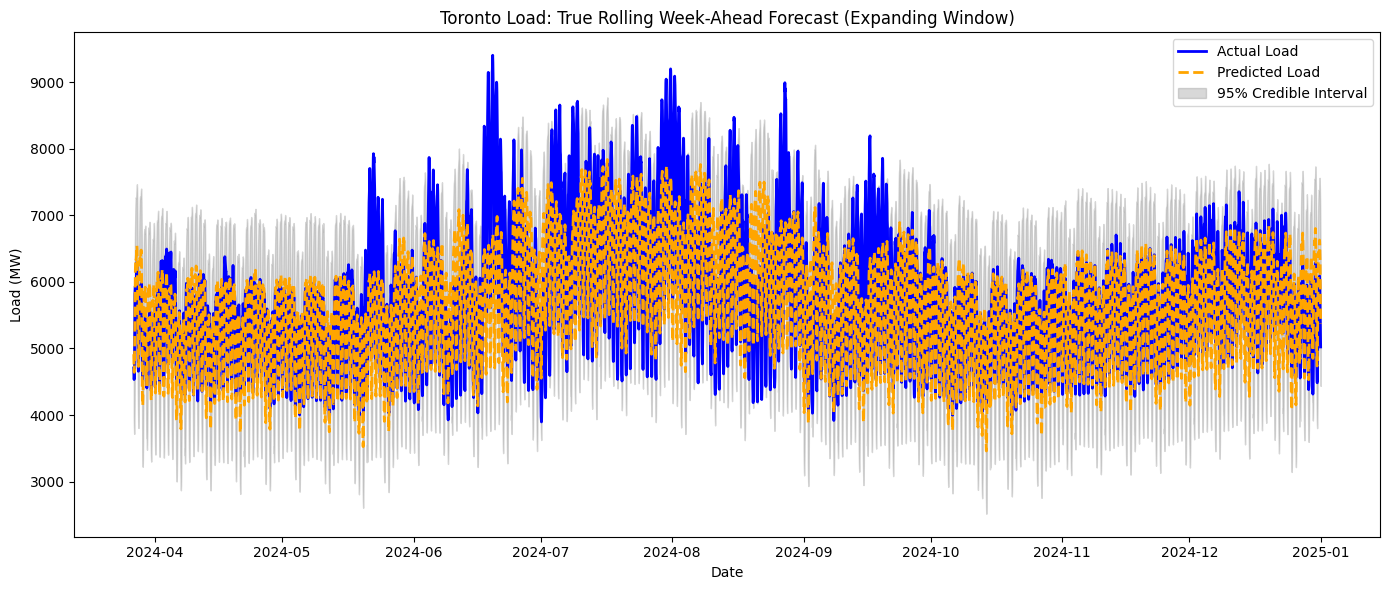

Niagara😈
  Initial train size: 54480 samples
  Starting rolling forecast...
    Week 1: Training on 54480 samples (added 0 new samples)
    Week 2: Training on 54648 samples (added 168 new samples)
    Week 3: Training on 54816 samples (added 336 new samples)


/var/folders/b8/b4rqhqs11cbcqlzjryxb92lw0000gn/T/ipykernel_8222/135573119.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[exog_features] = df[exog_features].apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)
/var/folders/b8/b4rqhqs11cbcqlzjryxb92lw0000gn/T/ipykernel_8222/135573119.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[exog_features] = df[exog_features].apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)


    Week 10: Training on 55992 samples (added 1512 new samples)
  Week 10/40 completed
    Week 20: Training on 57672 samples (added 3192 new samples)
  Week 20/40 completed
    Week 20: Training on 57672 samples (added 3192 new samples)
  Week 20/40 completed
    Week 30: Training on 59352 samples (added 4872 new samples)
  Week 30/40 completed
    Week 30: Training on 59352 samples (added 4872 new samples)
  Week 30/40 completed
    Week 40: Training on 61032 samples (added 6552 new samples)
  Week 40/40 completed
Niagara Rolling Bayesian Ridge RMSE: 72.38
  First 10 weeks RMSE: 65.88
  Last 10 weeks RMSE: 52.06
  Improvement: 13.83 MW (21.0%)
    Week 40: Training on 61032 samples (added 6552 new samples)
  Week 40/40 completed
Niagara Rolling Bayesian Ridge RMSE: 72.38
  First 10 weeks RMSE: 65.88
  Last 10 weeks RMSE: 52.06
  Improvement: 13.83 MW (21.0%)


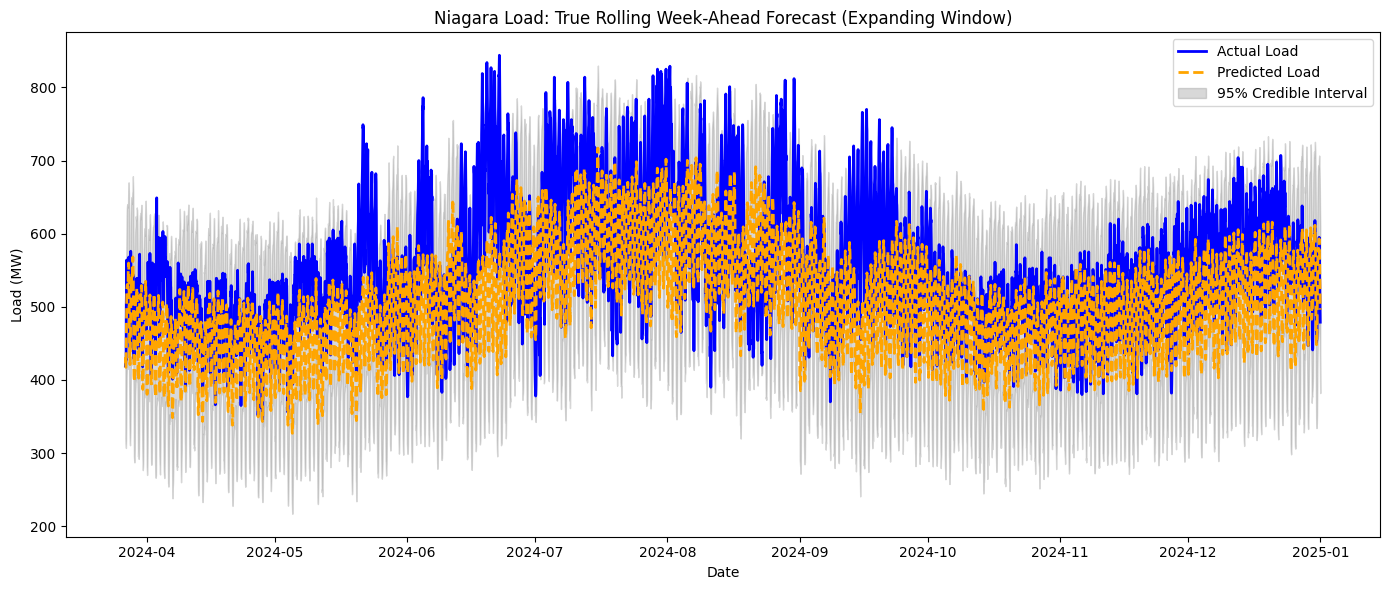

Ottawa😈
  Initial train size: 54480 samples
  Starting rolling forecast...
    Week 1: Training on 54480 samples (added 0 new samples)
    Week 2: Training on 54648 samples (added 168 new samples)
    Week 3: Training on 54816 samples (added 336 new samples)


/var/folders/b8/b4rqhqs11cbcqlzjryxb92lw0000gn/T/ipykernel_8222/135573119.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[exog_features] = df[exog_features].apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)
/var/folders/b8/b4rqhqs11cbcqlzjryxb92lw0000gn/T/ipykernel_8222/135573119.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[exog_features] = df[exog_features].apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)


    Week 10: Training on 55992 samples (added 1512 new samples)
  Week 10/40 completed
    Week 20: Training on 57672 samples (added 3192 new samples)
  Week 20/40 completed
    Week 20: Training on 57672 samples (added 3192 new samples)
  Week 20/40 completed
    Week 30: Training on 59352 samples (added 4872 new samples)
  Week 30/40 completed
    Week 30: Training on 59352 samples (added 4872 new samples)
  Week 30/40 completed
    Week 40: Training on 61032 samples (added 6552 new samples)
  Week 40/40 completed
Ottawa Rolling Bayesian Ridge RMSE: 111.02
  First 10 weeks RMSE: 85.83
  Last 10 weeks RMSE: 68.58
  Improvement: 17.25 MW (20.1%)
    Week 40: Training on 61032 samples (added 6552 new samples)
  Week 40/40 completed
Ottawa Rolling Bayesian Ridge RMSE: 111.02
  First 10 weeks RMSE: 85.83
  Last 10 weeks RMSE: 68.58
  Improvement: 17.25 MW (20.1%)


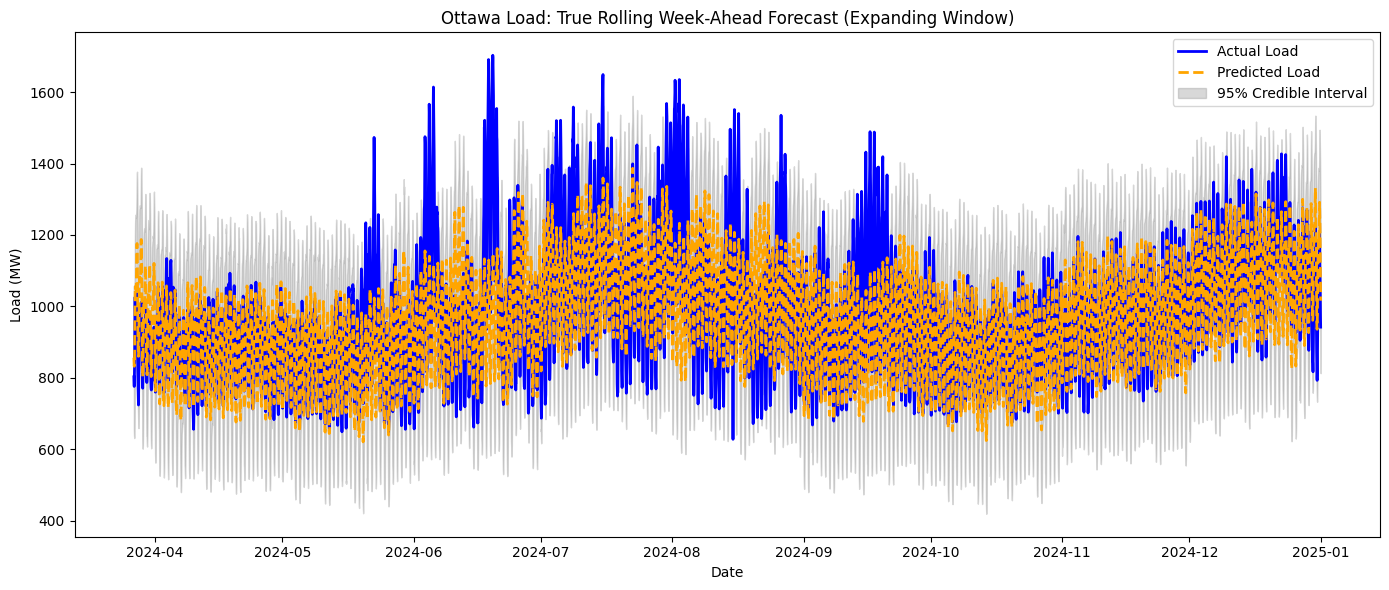

Southwest😈
  Initial train size: 54480 samples
  Starting rolling forecast...
    Week 1: Training on 54480 samples (added 0 new samples)
    Week 2: Training on 54648 samples (added 168 new samples)
    Week 3: Training on 54816 samples (added 336 new samples)
  Initial train size: 54480 samples
  Starting rolling forecast...
    Week 1: Training on 54480 samples (added 0 new samples)
    Week 2: Training on 54648 samples (added 168 new samples)
    Week 3: Training on 54816 samples (added 336 new samples)


/var/folders/b8/b4rqhqs11cbcqlzjryxb92lw0000gn/T/ipykernel_8222/135573119.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[exog_features] = df[exog_features].apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)
/var/folders/b8/b4rqhqs11cbcqlzjryxb92lw0000gn/T/ipykernel_8222/135573119.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[exog_features] = df[exog_features].apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)


    Week 10: Training on 55992 samples (added 1512 new samples)
  Week 10/40 completed
    Week 20: Training on 57672 samples (added 3192 new samples)
  Week 20/40 completed
    Week 20: Training on 57672 samples (added 3192 new samples)
  Week 20/40 completed
    Week 30: Training on 59352 samples (added 4872 new samples)
  Week 30/40 completed
    Week 30: Training on 59352 samples (added 4872 new samples)
  Week 30/40 completed
    Week 40: Training on 61032 samples (added 6552 new samples)
  Week 40/40 completed
Southwest Rolling Bayesian Ridge RMSE: 280.33
  First 10 weeks RMSE: 202.86
  Last 10 weeks RMSE: 195.26
  Improvement: 7.60 MW (3.7%)
    Week 40: Training on 61032 samples (added 6552 new samples)
  Week 40/40 completed
Southwest Rolling Bayesian Ridge RMSE: 280.33
  First 10 weeks RMSE: 202.86
  Last 10 weeks RMSE: 195.26
  Improvement: 7.60 MW (3.7%)


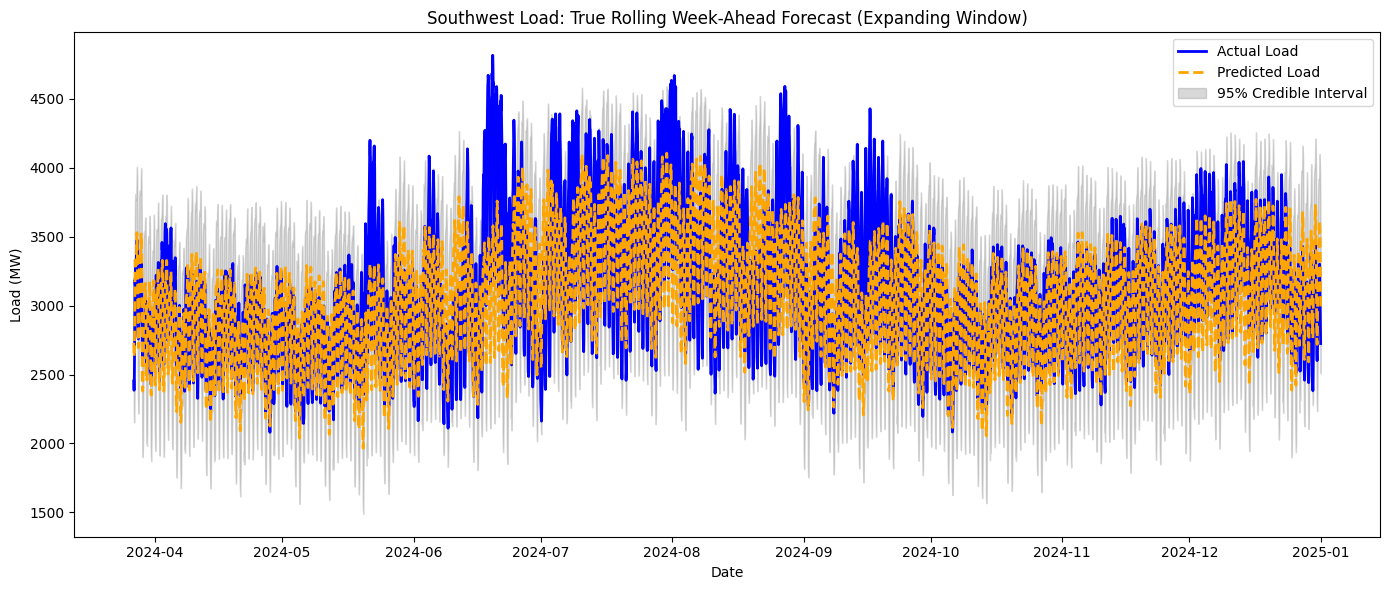

Bruce😈
  Initial train size: 54480 samples
  Starting rolling forecast...
    Week 1: Training on 54480 samples (added 0 new samples)
    Week 2: Training on 54648 samples (added 168 new samples)
    Week 3: Training on 54816 samples (added 336 new samples)
  Initial train size: 54480 samples
  Starting rolling forecast...
    Week 1: Training on 54480 samples (added 0 new samples)
    Week 2: Training on 54648 samples (added 168 new samples)
    Week 3: Training on 54816 samples (added 336 new samples)


/var/folders/b8/b4rqhqs11cbcqlzjryxb92lw0000gn/T/ipykernel_8222/135573119.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[exog_features] = df[exog_features].apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)
/var/folders/b8/b4rqhqs11cbcqlzjryxb92lw0000gn/T/ipykernel_8222/135573119.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[exog_features] = df[exog_features].apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)


    Week 10: Training on 55992 samples (added 1512 new samples)
  Week 10/40 completed
    Week 20: Training on 57672 samples (added 3192 new samples)
  Week 20/40 completed
    Week 20: Training on 57672 samples (added 3192 new samples)
  Week 20/40 completed
    Week 30: Training on 59352 samples (added 4872 new samples)
  Week 30/40 completed
    Week 30: Training on 59352 samples (added 4872 new samples)
  Week 30/40 completed
    Week 40: Training on 61032 samples (added 6552 new samples)
  Week 40/40 completed
Bruce Rolling Bayesian Ridge RMSE: 24.87
  First 10 weeks RMSE: 36.36
  Last 10 weeks RMSE: 14.92
  Improvement: 21.45 MW (59.0%)
    Week 40: Training on 61032 samples (added 6552 new samples)
  Week 40/40 completed
Bruce Rolling Bayesian Ridge RMSE: 24.87
  First 10 weeks RMSE: 36.36
  Last 10 weeks RMSE: 14.92
  Improvement: 21.45 MW (59.0%)


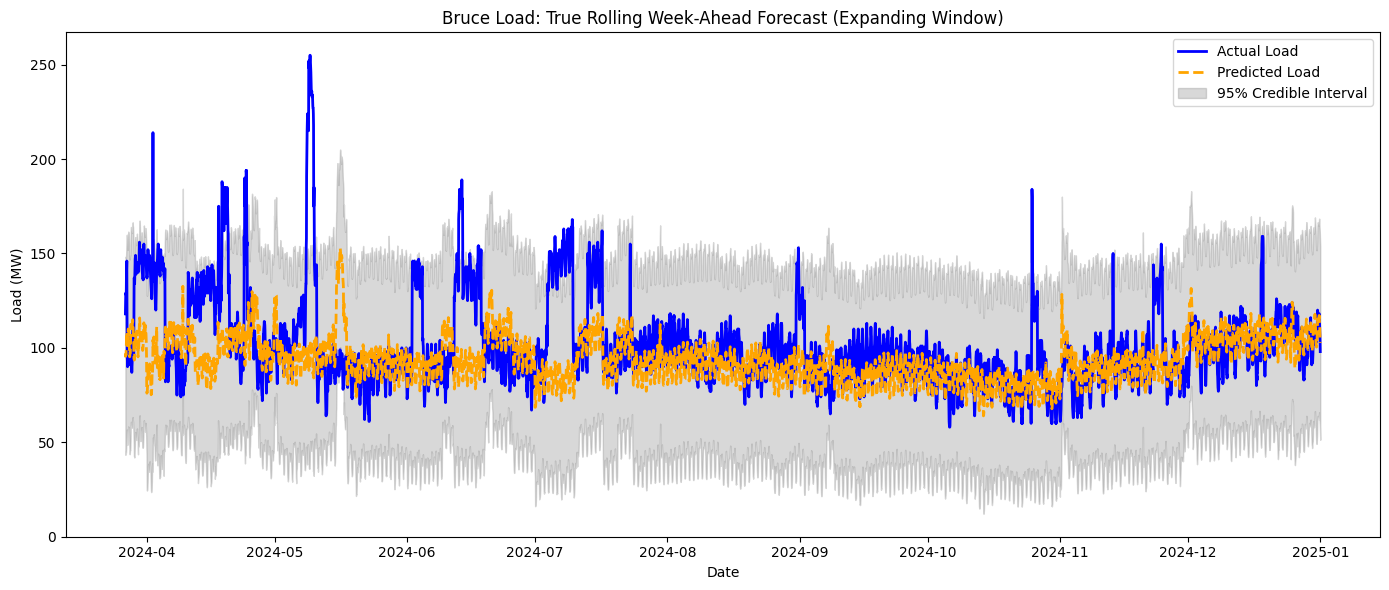

Essa😈
  Initial train size: 54480 samples
  Starting rolling forecast...
    Week 1: Training on 54480 samples (added 0 new samples)
    Week 2: Training on 54648 samples (added 168 new samples)
  Initial train size: 54480 samples
  Starting rolling forecast...
    Week 1: Training on 54480 samples (added 0 new samples)
    Week 2: Training on 54648 samples (added 168 new samples)


/var/folders/b8/b4rqhqs11cbcqlzjryxb92lw0000gn/T/ipykernel_8222/135573119.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[exog_features] = df[exog_features].apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)
/var/folders/b8/b4rqhqs11cbcqlzjryxb92lw0000gn/T/ipykernel_8222/135573119.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[exog_features] = df[exog_features].apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)


    Week 3: Training on 54816 samples (added 336 new samples)
    Week 10: Training on 55992 samples (added 1512 new samples)
  Week 10/40 completed
    Week 10: Training on 55992 samples (added 1512 new samples)
  Week 10/40 completed
    Week 20: Training on 57672 samples (added 3192 new samples)
  Week 20/40 completed
    Week 20: Training on 57672 samples (added 3192 new samples)
  Week 20/40 completed
    Week 30: Training on 59352 samples (added 4872 new samples)
  Week 30/40 completed
    Week 30: Training on 59352 samples (added 4872 new samples)
  Week 30/40 completed
    Week 40: Training on 61032 samples (added 6552 new samples)
  Week 40/40 completed
Essa Rolling Bayesian Ridge RMSE: 124.69
  First 10 weeks RMSE: 98.37
  Last 10 weeks RMSE: 106.99
  Improvement: -8.61 MW (-8.8%)
    Week 40: Training on 61032 samples (added 6552 new samples)
  Week 40/40 completed
Essa Rolling Bayesian Ridge RMSE: 124.69
  First 10 weeks RMSE: 98.37
  Last 10 weeks RMSE: 106.99
  Improvemen

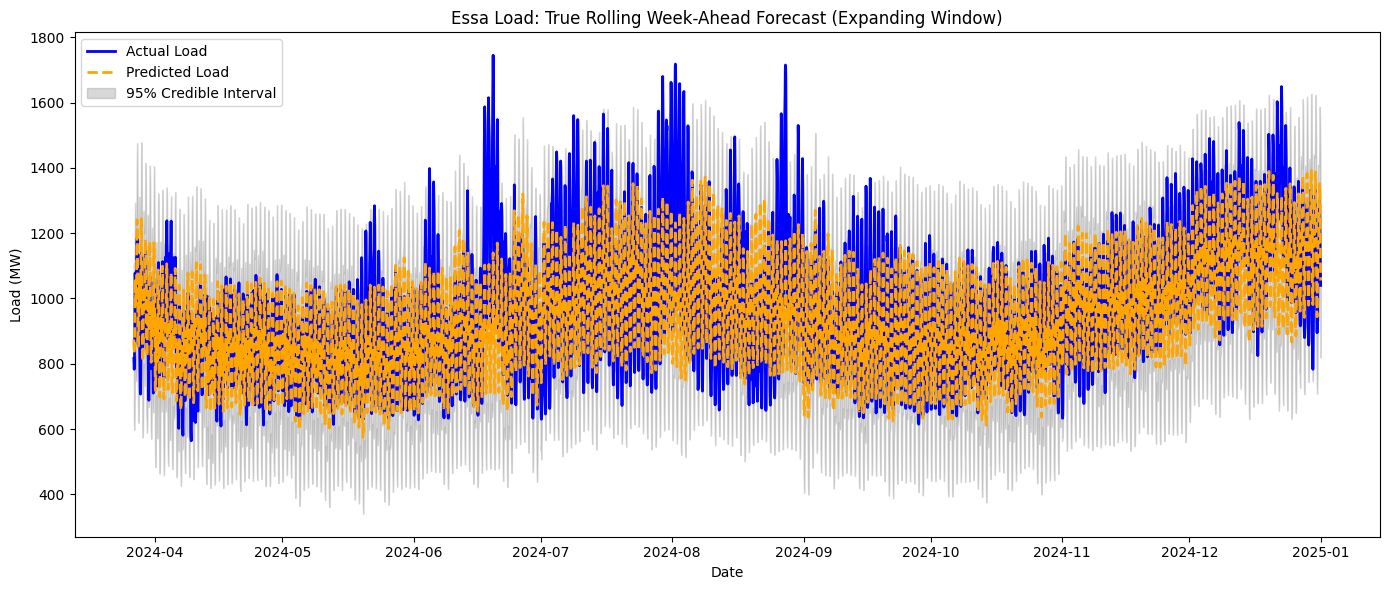

West😈
  Initial train size: 54480 samples
  Starting rolling forecast...
    Week 1: Training on 54480 samples (added 0 new samples)
    Week 2: Training on 54648 samples (added 168 new samples)
  Initial train size: 54480 samples
  Starting rolling forecast...
    Week 1: Training on 54480 samples (added 0 new samples)
    Week 2: Training on 54648 samples (added 168 new samples)


/var/folders/b8/b4rqhqs11cbcqlzjryxb92lw0000gn/T/ipykernel_8222/135573119.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[exog_features] = df[exog_features].apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)
/var/folders/b8/b4rqhqs11cbcqlzjryxb92lw0000gn/T/ipykernel_8222/135573119.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[exog_features] = df[exog_features].apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)


    Week 3: Training on 54816 samples (added 336 new samples)
    Week 10: Training on 55992 samples (added 1512 new samples)
  Week 10/40 completed
    Week 10: Training on 55992 samples (added 1512 new samples)
  Week 10/40 completed
    Week 20: Training on 57672 samples (added 3192 new samples)
  Week 20/40 completed
    Week 20: Training on 57672 samples (added 3192 new samples)
  Week 20/40 completed
    Week 30: Training on 59352 samples (added 4872 new samples)
  Week 30/40 completed
    Week 30: Training on 59352 samples (added 4872 new samples)
  Week 30/40 completed
    Week 40: Training on 61032 samples (added 6552 new samples)
  Week 40/40 completed
West Rolling Bayesian Ridge RMSE: 214.49
  First 10 weeks RMSE: 182.94
  Last 10 weeks RMSE: 196.77
  Improvement: -13.83 MW (-7.6%)
    Week 40: Training on 61032 samples (added 6552 new samples)
  Week 40/40 completed
West Rolling Bayesian Ridge RMSE: 214.49
  First 10 weeks RMSE: 182.94
  Last 10 weeks RMSE: 196.77
  Improve

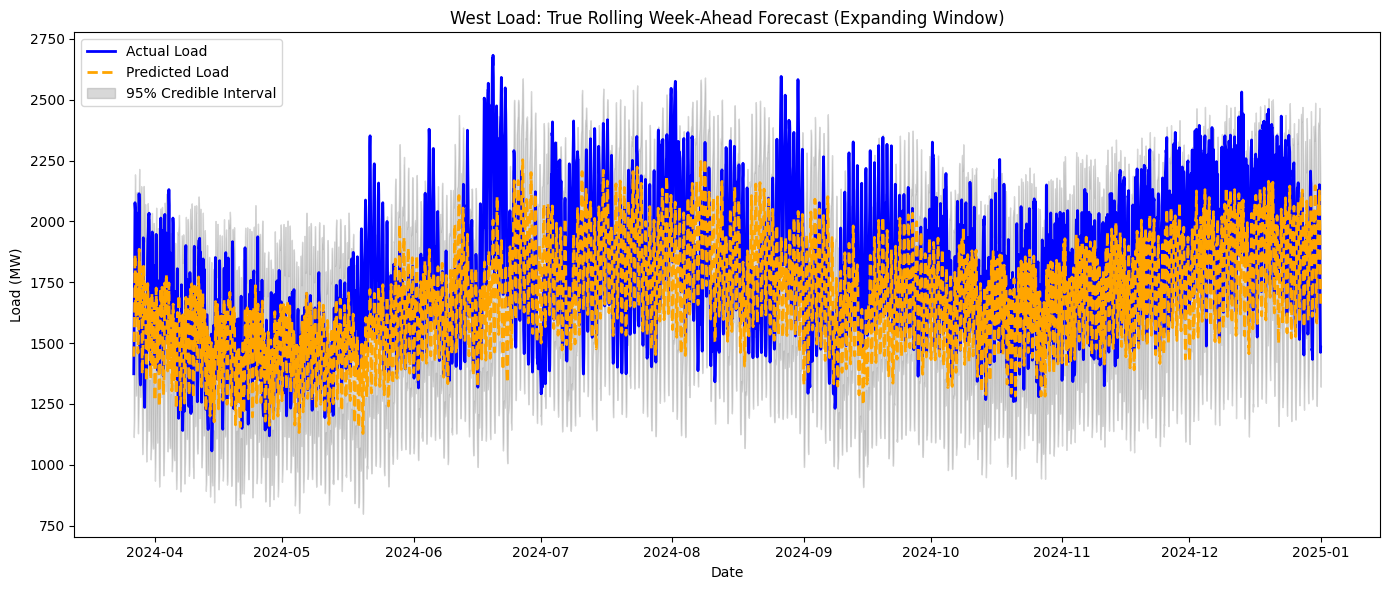

East😈
  Initial train size: 54480 samples
  Starting rolling forecast...
    Week 1: Training on 54480 samples (added 0 new samples)
    Week 2: Training on 54648 samples (added 168 new samples)
  Initial train size: 54480 samples
  Starting rolling forecast...
    Week 1: Training on 54480 samples (added 0 new samples)
    Week 2: Training on 54648 samples (added 168 new samples)


/var/folders/b8/b4rqhqs11cbcqlzjryxb92lw0000gn/T/ipykernel_8222/135573119.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[exog_features] = df[exog_features].apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)
/var/folders/b8/b4rqhqs11cbcqlzjryxb92lw0000gn/T/ipykernel_8222/135573119.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[exog_features] = df[exog_features].apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)


    Week 3: Training on 54816 samples (added 336 new samples)
    Week 10: Training on 55992 samples (added 1512 new samples)
  Week 10/40 completed
    Week 10: Training on 55992 samples (added 1512 new samples)
  Week 10/40 completed
    Week 20: Training on 57672 samples (added 3192 new samples)
  Week 20/40 completed
    Week 20: Training on 57672 samples (added 3192 new samples)
  Week 20/40 completed
    Week 30: Training on 59352 samples (added 4872 new samples)
  Week 30/40 completed
    Week 30: Training on 59352 samples (added 4872 new samples)
  Week 30/40 completed
    Week 40: Training on 61032 samples (added 6552 new samples)
  Week 40/40 completed
East Rolling Bayesian Ridge RMSE: 124.04
  First 10 weeks RMSE: 117.71
  Last 10 weeks RMSE: 136.16
  Improvement: -18.46 MW (-15.7%)
    Week 40: Training on 61032 samples (added 6552 new samples)
  Week 40/40 completed
East Rolling Bayesian Ridge RMSE: 124.04
  First 10 weeks RMSE: 117.71
  Last 10 weeks RMSE: 136.16
  Improv

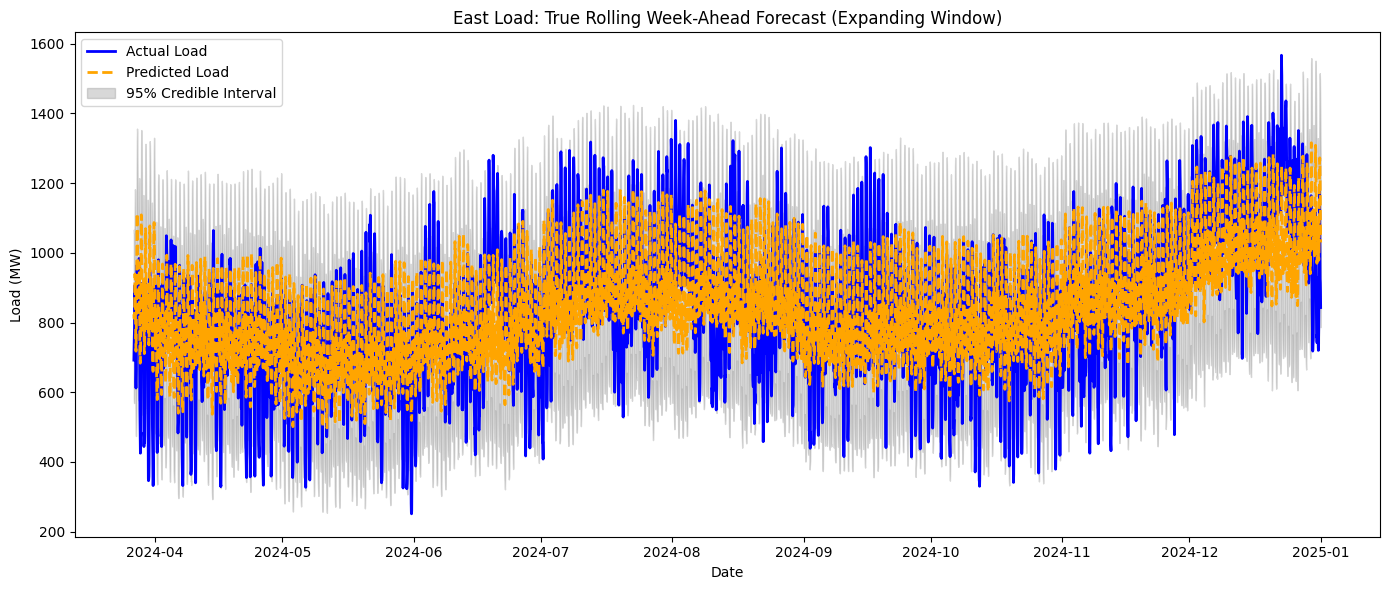

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

models = {}
results = {}

# loop through each zone

for zone in ['Toronto', 'Niagara', 'Ottawa', 'Southwest', 'Bruce', 'Essa', 'West', 'East']: 
    print(zone + "😈") # i use emojis for clarity at times
    

    price_mapping = {
        'Toronto': 'Toronto_Darlington',
        'Niagara': 'Niagara_BECK2',
        'Ottawa': 'Ottawa_TAOHSC',
        'Southwest': 'South West_GerdauCam',
        'Bruce': 'Bruce_BruceB',
        'Essa': 'Essa_Desjoachims',
        'West': 'West_Greenfield',
        'East': 'East_Saunders'
    }
    price_col = price_mapping[zone]
    
    data = prepare_toronto_load_data(
        datamerged,
        zone=zone,
        weather_vars=['temp_C_t2m', 'u10', 'tp'],
        extra_lags=[
            (zone, '1w_load', 168),        # Use zone-specific load
            (price_col, '1w_price', 168)   # Use zone-specific price
        ],
        test_weeks=40,
        include_daily_seasonality=True
    )
    
    train = data['train']
    test = data['test']
    target_train = data['target_train']
    target_test = data['target_test']
    exog_features = data['exog_features']

    # ----------------------
    # Rolling week-ahead forecast with expanding training window
    # ----------------------
    forecast_horizon = 168  # 1 week
    max_weeks = 40          # limit number of weeks to forecast
    
    # Get full dataset for rolling window
    full_data = data['toronto_data']
    
    # Find initial training end index (start of test set)
    initial_train_end = full_data.index.get_loc(test.index[0])
    
    all_pred = []
    all_actual = []
    all_lower = []
    all_upper = []
    all_std = []

    # Print initial info
    print(f"  Initial train size: {initial_train_end} samples")
    print(f"  Starting rolling forecast...")
    
    for week in range(max_weeks):
        # calculate current training window end (expands each week)
        current_train_end = initial_train_end + (week * forecast_horizon)
        
        # enough data for forecast
        forecast_end = current_train_end + forecast_horizon
        if forecast_end > len(full_data):
            # Adjust for last partial week
            forecast_end = len(full_data)
            if forecast_end <= current_train_end:
                break
        
        # Expand training set to include all data up to current point
        expanding_train = full_data.iloc[:current_train_end]
        expanding_target = expanding_train[zone].astype(float)
        
        # diagnostic: print training size for first few weeks
        if week < 3 or (week + 1) % 10 == 0:
            print(f"    Week {week + 1}: Training on {len(expanding_train)} samples (added {week * forecast_horizon} new samples)")
        
        # get next week's data for forecasting
        forecast_data = full_data.iloc[current_train_end:forecast_end]
        actual_values = forecast_data[zone].astype(float)
        
        # Prepare features
        X_train = expanding_train[exog_features].astype(float)
        X_forecast = forecast_data[exog_features].astype(float)
        
        # Scale features with expanding training set
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_forecast_scaled = scaler.transform(X_forecast)

        # Train Bayesian Ridge on expanding training set
        model = BayesianRidge()
        model.fit(X_train_scaled, expanding_target)

        # Forecast current week with standard deviation (proper uncertainty)
        pred_mean, pred_std = model.predict(X_forecast_scaled, return_std=True)

        # 95% credible interval
        lower = pred_mean - 1.96 * pred_std
        upper = pred_mean + 1.96 * pred_std

        # Store predictions, actuals, intervals
        all_pred.extend(pred_mean)
        all_actual.extend(actual_values.values)
        all_lower.extend(lower)
        all_upper.extend(upper)
        all_std.extend(pred_std)
        
        # progress indicator
        if (week + 1) % 10 == 0:
            print(f"  Week {week + 1}/{max_weeks} completed")

    # ----------------------
    # Evaluate
    # ----------------------
    rmse = np.sqrt(mean_squared_error(all_actual, all_pred))
    
    # calculate RMSE for first 10 weeks vs last 10 weeks
    week_samples = forecast_horizon
    first_10_weeks = week_samples * 10
    last_10_weeks_start = len(all_actual) - (week_samples * 10)
    
    rmse_first_10 = np.sqrt(mean_squared_error(all_actual[:first_10_weeks], all_pred[:first_10_weeks]))
    rmse_last_10 = np.sqrt(mean_squared_error(all_actual[last_10_weeks_start:], all_pred[last_10_weeks_start:]))
    
    print(f'{zone} Rolling Bayesian Ridge RMSE: {rmse:.2f}')
    print(f'  First 10 weeks RMSE: {rmse_first_10:.2f}')
    print(f'  Last 10 weeks RMSE: {rmse_last_10:.2f}')
    print(f'  Improvement: {rmse_first_10 - rmse_last_10:.2f} MW ({((rmse_first_10 - rmse_last_10) / rmse_first_10 * 100):.1f}%)')

    # Store the last trained model
    models[zone] = (model, scaler)
    
    # ----------------------
    # Plot results with credible intervals
    # ----------------------
    # Reconstruct forecast index
    forecast_index = full_data.index[initial_train_end:initial_train_end + len(all_pred)]
    forecast_actual = full_data[zone].iloc[initial_train_end:initial_train_end + len(all_pred)]
    
    results[zone] = {
        'predictions': all_pred,
        'actuals': all_actual,
        'lower': all_lower,
        'upper': all_upper,
        'std': all_std,
        'index': forecast_index
    }
    
    plt.figure(figsize=(14, 6))
    plt.plot(forecast_index, forecast_actual, label='Actual Load', color='blue', linewidth=2)
    plt.plot(forecast_index, all_pred, linestyle='--', label='Predicted Load', color='orange', linewidth=2)
    
    plt.fill_between(
        forecast_index,
        all_lower,
        all_upper,
        color='gray',
        alpha=0.3,
        label='95% Credible Interval'
    )
    
    plt.title(f'{zone} Load: True Rolling Week-Ahead Forecast (Expanding Window)')
    plt.xlabel('Date')
    plt.ylabel('Load (MW)')
    plt.legend()
    plt.tight_layout()
    plt.show()


Comparison of Model Uncertainty:
        Zone  Average Uncertainty (std)  Average Load  \
4      Bruce                    26.5271      101.6491   
7       East                   123.9967      833.8001   
5       Essa                   120.0619      969.9536   
2     Ottawa                   103.4556      988.5338   
1    Niagara                    57.4793      556.2638   
6       West                   171.3614     1773.6180   
0    Toronto                   475.9112     5800.5790   
3  Southwest                   246.9982     3139.8754   

   Relative Uncertainty (%)  
4                   26.0968  
7                   14.8713  
5                   12.3781  
2                   10.4656  
1                   10.3331  
6                    9.6617  
0                    8.2045  
3                    7.8665  

Most relatively uncertain zone: Bruce with a relative uncertainty of 26.10%.


/var/folders/b8/b4rqhqs11cbcqlzjryxb92lw0000gn/T/ipykernel_8222/1796011365.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Relative Uncertainty (%)', y='Zone', data=uncertainty_df, palette='viridis')


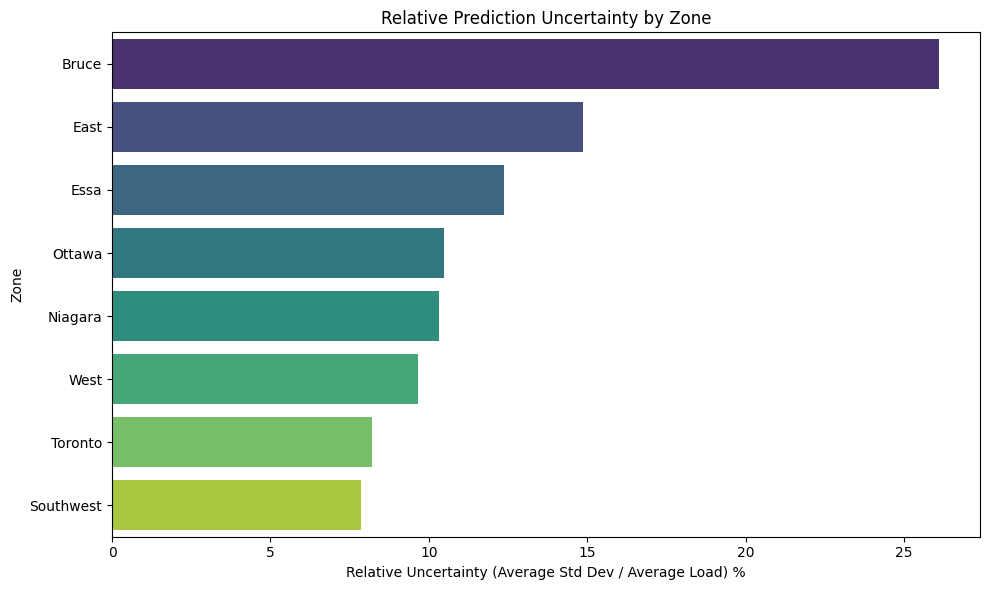

In [ ]:
# compare the uncertainty relative to load size
uncertainty_data = []
for zone, result_data in results.items():
    avg_uncertainty = np.mean(result_data['std'])
    avg_load = np.mean(result_data['actuals'])
    relative_uncertainty = (avg_uncertainty / avg_load) * 100  # as a percentage
    uncertainty_data.append({
        'Zone': zone,
        'Average Uncertainty (std)': avg_uncertainty,
        'Average Load': avg_load,
        'Relative Uncertainty (%)': relative_uncertainty
    })

uncertainty_df = pd.DataFrame(uncertainty_data)
uncertainty_df = uncertainty_df.sort_values(by='Relative Uncertainty (%)', ascending=False)

print("Comparison of Model Uncertainty:")
print(uncertainty_df)

most_uncertain_zone = uncertainty_df.iloc[0]
print(f"\nMost relatively uncertain zone: {most_uncertain_zone['Zone']} with a relative uncertainty of {most_uncertain_zone['Relative Uncertainty (%)']:.2f}%.")


plt.figure(figsize=(10, 6))
sns.barplot(x='Relative Uncertainty (%)', y='Zone', data=uncertainty_df, palette='viridis')
plt.title('Relative Prediction Uncertainty by Zone')
plt.xlabel('Relative Uncertainty (Average Std Dev / Average Load) %')
plt.ylabel('Zone')
plt.tight_layout()
plt.show()
